![](https://wallpapertag.com/wallpaper/full/e/0/2/750148-new-titanic-sinking-wallpapers-1920x1088-for-iphone-6.jpg)

# Data Cleaning and Classification using Ensemble Models

This notebook describes the steps used to clean and predict passenger survival in the [Kaggle Titanic](https://www.kaggle.com/c/titanic/overview) dataset.

## Overall approach

 - We will start by **exploring** the provided columns and using our prior knowledge to reason about their utility for predicting survival
 - Then we'll note any **missing values** and go over the strategy to fill/impute them
 - Describe **transformations** of features
 - **Engineer new, more informative features** from the existing features
 - **Visualize the dataset structure** in a low-dimensional projection
 - **Identify clusters** in the projection and use them to assist classification
 - **Evaluate the classification performance** of four algorithms: Random Forests, k Nearest Neighbors, SVMs, and MLPs
 - Finally, combine the predictions of the four algorithms into an **ensemble model**
 

# Imports

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Keep the results reproducible
random_seed = 31415

from numpy.random import seed
from tensorflow import set_random_seed

seed(random_seed)
set_random_seed(random_seed)

# Read in the training dataset

In [56]:
df_train = pd.read_csv('input/titanic/train.csv')
df_live = pd.read_csv('input/titanic/test.csv')

In [3]:
df_train

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

# Feature exploration

In [54]:
import pandas_profiling
pandas_profiling.ProfileReport(df_train)

In [5]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df_live)

# Column Notes

* Target variable is `Survived` 0/1. Balance is is 61/39%. Guessing 0 would be 61% accurate.
* `Age` will need missing value imputation
* `Cabin` may contain useful ship location info (it was night, so most were sleeping in their cabins), but also many missing values
* `Embarked` is a categorical port of embarkation. This should be coded as 1-C=Cherbourg, 2=S=Southampton, and 3=Q=Queenstown to reflect likely onboarding order
* `Fare` has a long tail - should be log transformed. Live set has missing values. 
* `Name` - ingore for now. It's probable that features of one's name affected rescue decisions by others. Would need more processing to include that information.
* `Parch` - number of parents/children aboard. This needs to be separated. Younger children were probably more likelly to survive if parents were onboard, while parents less likelly because they stayed onboard longer to save the children. Also, being an adult with older parents is different from being a child with adult parents. 0-case is probably very informative. Could use Age column to guess if this number reflects parents or children.
* `Pclass`, `Sex` - probably very predictive
* `SibSp` - number of siblings/spouses onboard. Also could use `Age` to guess which these are.
* `Ticket` - its not clear how informative this is. Duplicates suggest family. Characters may suggest ticket agent.


# Fill missing values

In [57]:
def fill_missing(df_target):
    # Label missing cabins 'X', and lowercase everything
    df_target["Cabin"] = np.char.lower(np.array(df_target["Cabin"].fillna('X'),dtype='str'))

    # Replace missing embarked with mode
    df_target['Embarked'] = df_target["Embarked"].fillna(df_train["Embarked"].mode())
    
    # Replace missing fare with median
    df_target['Fare'] = df_target["Fare"].fillna(df_train["Fare"].median())
    
    
fill_missing(df_train)
fill_missing(df_live)

# Transform features

In [58]:
def transform_features(df_target):
    df_target["logFare"] = np.log(df_target["Fare"]+1)                

    # Encode sex
    df_target["male"] = (df_target["Sex"] == "male") * 1

    # 1-hot encode first cabin letter
    import re
    rx = re.compile('^(\w)')

    def cabin_letter(cabin):
        return rx.search(cabin).groups()[0]

    df_target["CabinLetter"] = list(map(cabin_letter, df_target["Cabin"]))
    for letter in df_train["CabinLetter"].unique():
        df_target["Cabin_"+letter] = 1*(df_target["CabinLetter"] == letter)
        
transform_features(df_train)
transform_features(df_live)

In [59]:
# Missing age values will be imputed
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

age_predictors = ['Fare','Pclass','Parch','SibSp', 'male']

# Select non-missing age rows as input to predict missing age row values
X_age = df_train.loc[df_train['Age'].notna(), df_train.columns.isin(age_predictors)].values
y_age = df_train.loc[df_train['Age'].notna(), 'Age'].values

# Use support vector regression to impute age
model_age = SVR(C=1.0, epsilon=0.2)
model_age.fit(X_age, y_age)


def fill_age(df_target):
    # Select missing age rows
    X_age_missing = df_target.loc[df_target['Age'].isna(), df_target.columns.isin(age_predictors)].values
    
    # Impute age using the regressor
    df_target.loc[df_target['Age'].isna(), 'Age'] = model_age.predict(X_age_missing)
    
fill_age(df_train)
fill_age(df_live)

# Create new features

In [60]:
def add_new_features(df_target):
    # Total family
    df_target['FamilyTotal'] = df_target['SibSp'] + df_target["Parch"]

    # 1-hot encode embarkation port
    Embarked_Dummies = pd.get_dummies(df_target['Embarked'])
    df_target['Embarked_C'] = Embarked_Dummies['C']
    df_target['Embarked_S'] = Embarked_Dummies['S']
    df_target['Embarked_Q'] = Embarked_Dummies['Q']

    # For children, guess that they traveled with parents
    df_target['Probable_Parents'] = np.select(
        [
            (df_target['Age'] < 18),
            (df_target['Age'] >= 18),
        ],
        [
            df_target['Parch'],
            0
        ]
    )

    # For adults, guess that they traveled with children
    df_target['Probable_Children'] = np.select(
        [
            (df_target['Age'] >= 18),
            (df_target['Age'] < 18),
        ],
        [
            df_target['Parch'],
            0
        ]
    )

    # Guess that children were not married and were traveling with siblings if any
    # And that adults had one spouse if any, with rest, if any, being siblings
    df_target['Probable_Siblings'] = np.select(
        [
            (df_target['Age'] < 18),
            (df_target['Age'] >= 18) & (df_target['SibSp'] > 1),
            (df_target['Age'] >= 18) & (df_target['SibSp'] <= 1),
        ],
        [
            df_target['SibSp'],
            df_target['SibSp'] - 1,
            0
        ]
    )

    # Guess that children did not travel with spouses
    # Guess that adults traveled with spouse first
    df_target['Probable_Spouse'] = np.select(
        [
            (df_target['Age'] < 18),
            (df_target['Age'] >= 18) & (df_target['SibSp'] > 0),
            (df_target['Age'] >= 18) & (df_target['SibSp'] == 0),
        ],
        [
            0,
            1,
            0
        ]
    )
    
add_new_features(df_train)
add_new_features(df_live)

# Classification

As with all ML problems, we don't know which algorithm will work best ahead of time. Here, I will try different classes of algorithms and see which one performs best. Later, I will combine the algorithms into an enseble classifier, which will probably perform better than any of the individual models.

In [61]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'logFare', 'male',
       'CabinLetter', 'Cabin_x', 'Cabin_c', 'Cabin_e', 'Cabin_g', 'Cabin_d',
       'Cabin_a', 'Cabin_b', 'Cabin_f', 'Cabin_t', 'FamilyTotal', 'Embarked_C',
       'Embarked_S', 'Embarked_Q', 'Probable_Parents', 'Probable_Children',
       'Probable_Siblings', 'Probable_Spouse'],
      dtype='object')

In [62]:
# Select columns for classification
def select_features(df_target, include_y=True):
    columns = ['Pclass', 'Age', 'logFare', 'male', 'SibSp', 'Parch', 
               'Embarked_C', 'Embarked_S', 'Embarked_Q', 'FamilyTotal',]
#                 'Cabin_x', 'Cabin_c', 'Cabin_e', 'Cabin_g', 'Cabin_d',
#                 'Cabin_a', 'Cabin_b', 'Cabin_f', 'Cabin_t',
#                 'Probable_Parents', 'Probable_Children', 'Probable_Siblings',
#                 'Probable_Spouse']

    X = df_target.loc[:,df_target.columns.isin(columns)].values
    
    if include_y:
        y = df_target.loc[:, 'Survived'].values
    else:
        y = None
    
    return X, y

X, y = select_features(df_train)
X_live, _ = select_features(df_live, include_y=False)

In [63]:
# Split to train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [64]:
# Scale features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_live = scaler.transform(X_live)

In [65]:
# Import evaluation measures
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define a model report
def model_report(y_test, y_pred):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    print('Accuracy:', accuracy_score(y_test, y_pred))

# Visualize a lower dimension projection

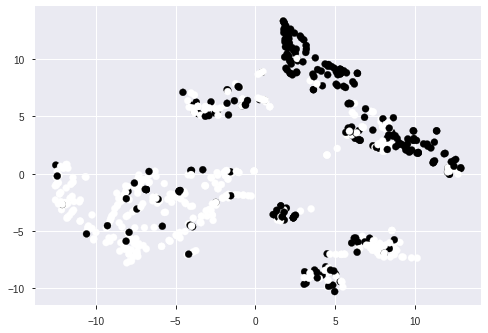

In [66]:
from openTSNE import TSNE

tsne = TSNE(
    n_components=3,
    perplexity=30,
    early_exaggeration=12,
    random_state=random_seed,
    n_iter=1000,
    neighbors='approx',
    negative_gradient_method='bh',
    theta=0.8
)


tsne_train = tsne.fit(X_train)

plt.scatter(tsne_train[:,0], tsne_train[:,1], c=y_train)


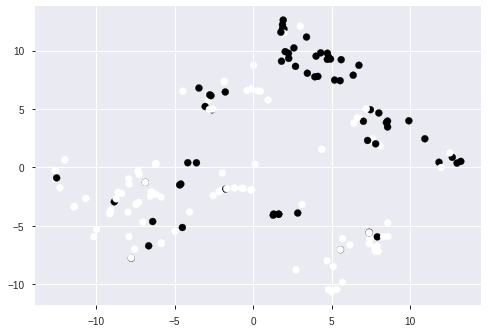

In [67]:
# Project test set to the same embedding
tsne_test = tsne_train.transform(X_test)
plt.scatter(tsne_test[:,0], tsne_test[:,1], c=y_test)

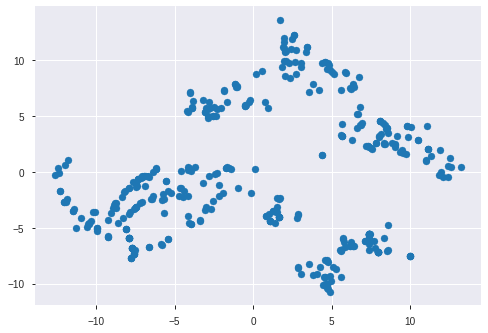

In [68]:
# Project live as well
tsne_live = tsne_train.transform(X_live)
plt.scatter(tsne_live[:,0], tsne_live[:,1])

# Label clusters

 - Using HDBSCAN identify the clusters and label the rows
 - Cluster using the train set, then assign cluster labels to the test set

Found 6 clusters


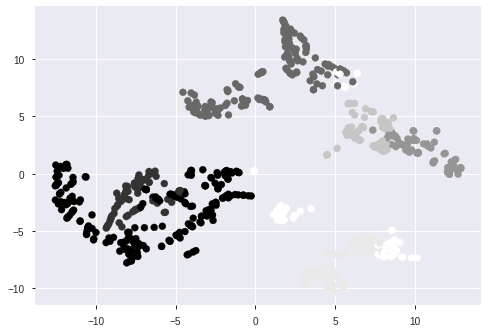

In [69]:
from hdbscan import HDBSCAN, approximate_predict

hdbscan = HDBSCAN(min_cluster_size=50, prediction_data=True)
hdbscan.fit(tsne_train)

tsne_train_clusters = hdbscan.labels_

print('Found %d clusters'%(hdbscan.labels_.max()+1))
plt.scatter(tsne_train[:,0], tsne_train[:,1], c=tsne_train_clusters)

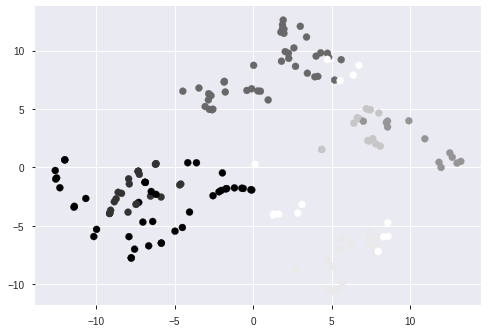

In [70]:
# Get cluster assignments for test set
tsne_test_clusters = approximate_predict(hdbscan, tsne_test)[0]


plt.scatter(tsne_test[:,0], tsne_test[:,1], c=tsne_test_clusters)

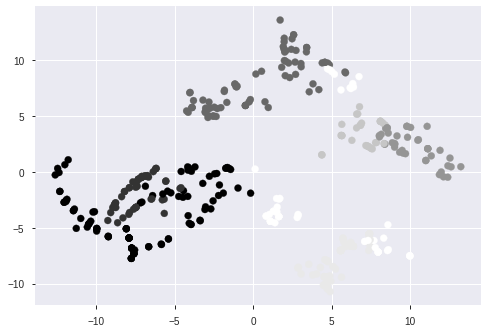

In [71]:
# Get cluster assignments for live set
tsne_live_clusters = approximate_predict(hdbscan, tsne_live)[0]


plt.scatter(tsne_live[:,0], tsne_live[:,1], c=tsne_live_clusters)

In [72]:
n_clusters = tsne_test_clusters.max()+1

# 1-hot encode train cluster
tsne_train_clusters = np.eye(n_clusters)[tsne_train_clusters.reshape(-1)]

# 1-hot encode test clusters
tsne_test_clusters = np.eye(n_clusters)[tsne_test_clusters.reshape(-1)]

# 1-hot encode live clusters
tsne_live_clusters = np.eye(n_clusters)[tsne_live_clusters.reshape(-1)]

In [73]:
# Add the cluster labels as 1-hot features to the train/test/live sets
X_train = np.concatenate((X_train, tsne_train_clusters), 1)
X_test = np.concatenate((X_test, tsne_test_clusters), 1)
X_live = np.concatenate((X_live, tsne_live_clusters), 1)

In [74]:
X_train.shape, X_test.shape, X_live.shape

((712, 16), (179, 16), (418, 16))

# Classify using Random Forests

In [75]:
from sklearn.ensemble import RandomForestClassifier

# Search for n_estimators value that produces largest accuracy
best_acc = 0
best_n = 0
best_model_rf = None

for n_estimators in range(1, 50, 1):
    model_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_seed)
    model_rf.fit(X_train, y_train)
    
    y_pred = model_rf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    print('Trees: %d, accuracy %f'%(n_estimators, acc))
    
    if acc > best_acc:
        best_acc = acc
        best_n = n_estimators
        best_model_rf = model_rf
        
# Get the best n_estimators
print('Best n_estimators: %s with accuracy: %f'%(best_n, best_acc))

# Get best predictions
y_pred = best_model_rf.predict(X_test)

model_report(y_test, y_pred)

Trees: 1, accuracy 0.776536
Trees: 2, accuracy 0.776536
Trees: 3, accuracy 0.787709
Trees: 4, accuracy 0.787709
Trees: 5, accuracy 0.782123
Trees: 6, accuracy 0.770950
Trees: 7, accuracy 0.782123
Trees: 8, accuracy 0.793296
Trees: 9, accuracy 0.793296
Trees: 10, accuracy 0.782123
Trees: 11, accuracy 0.798883
Trees: 12, accuracy 0.793296
Trees: 13, accuracy 0.782123
Trees: 14, accuracy 0.787709
Trees: 15, accuracy 0.782123
Trees: 16, accuracy 0.782123
Trees: 17, accuracy 0.782123
Trees: 18, accuracy 0.793296
Trees: 19, accuracy 0.793296
Trees: 20, accuracy 0.798883
Trees: 21, accuracy 0.793296
Trees: 22, accuracy 0.804469
Trees: 23, accuracy 0.798883
Trees: 24, accuracy 0.793296
Trees: 25, accuracy 0.793296
Trees: 26, accuracy 0.787709
Trees: 27, accuracy 0.787709
Trees: 28, accuracy 0.793296
Trees: 29, accuracy 0.776536
Trees: 30, accuracy 0.787709
Trees: 31, accuracy 0.776536
Trees: 32, accuracy 0.787709
Trees: 33, accuracy 0.793296
Trees: 34, accuracy 0.793296
Trees: 35, accuracy 0.7

# Classify using K-Nearest Neighbors

In [76]:
from sklearn.neighbors import KNeighborsClassifier

best_neighbors = 0
best_accuracy = 0
best_model_knn = None

# Search for n_neighbors with highest accuracy
for n_neighbors in range(1, 50, 1):
    model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    model_knn.fit(X_train, y_train)

    y_pred = model_knn.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    print('Neighbors: %d, accuracy %f'%(n_neighbors, acc))
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_neighbors = n_neighbors
        best_model_knn = model_knn
        


Neighbors: 1, accuracy 0.715084
Neighbors: 2, accuracy 0.770950
Neighbors: 3, accuracy 0.782123
Neighbors: 4, accuracy 0.793296
Neighbors: 5, accuracy 0.782123
Neighbors: 6, accuracy 0.793296
Neighbors: 7, accuracy 0.776536
Neighbors: 8, accuracy 0.787709
Neighbors: 9, accuracy 0.776536
Neighbors: 10, accuracy 0.821229
Neighbors: 11, accuracy 0.765363
Neighbors: 12, accuracy 0.804469
Neighbors: 13, accuracy 0.782123
Neighbors: 14, accuracy 0.821229
Neighbors: 15, accuracy 0.793296
Neighbors: 16, accuracy 0.826816
Neighbors: 17, accuracy 0.787709
Neighbors: 18, accuracy 0.804469
Neighbors: 19, accuracy 0.776536
Neighbors: 20, accuracy 0.793296
Neighbors: 21, accuracy 0.782123
Neighbors: 22, accuracy 0.787709
Neighbors: 23, accuracy 0.782123
Neighbors: 24, accuracy 0.787709
Neighbors: 25, accuracy 0.770950
Neighbors: 26, accuracy 0.793296
Neighbors: 27, accuracy 0.793296
Neighbors: 28, accuracy 0.798883
Neighbors: 29, accuracy 0.782123
Neighbors: 30, accuracy 0.798883
Neighbors: 31, accu

In [77]:
# Get the best neighbors
print('Best Neighbors: %d, accuracy %f'%(best_neighbors, best_accuracy))

# Get best predictions
y_pred = best_model_knn.predict(X_test)

model_report(y_test, y_pred)

Best Neighbors: 16, accuracy 0.826816
Confusion Matrix:
[[105   7]
 [ 24  43]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       112
           1       0.86      0.64      0.74        67

    accuracy                           0.83       179
   macro avg       0.84      0.79      0.80       179
weighted avg       0.83      0.83      0.82       179

Accuracy: 0.8268156424581006


# Classify using Support Vector Machines

In [78]:
from sklearn.svm import SVC as SVM

best_accuracy = 0
best_C_gamma = None
best_model_svm = None

# Find the C-gamma combination with best accuracy
for C in np.linspace(0.1, 2.5, 10):
    for gamma in np.linspace(0.05, 0.2, 10):
        model_svm = SVM(C=C, gamma=gamma)
        model_svm.fit(X_train, y_train)

        y_pred = model_svm.predict(X_test)

        acc = accuracy_score(y_test, y_pred)

        print('C-gamma combination: %f-%f, accuracy %f'%(C,gamma, acc))
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_C_gamma = (C, gamma)
            best_model_svm = model_svm
            
# Get the C-gamma combination
print('Best C-gamma combination: %f-%f, accuracy %f'%(best_C_gamma[0],best_C_gamma[1], best_accuracy))

# Get best predictions
y_pred = best_model_svm.predict(X_test)

C-gamma combination: 0.100000-0.050000, accuracy 0.782123
C-gamma combination: 0.100000-0.066667, accuracy 0.782123
C-gamma combination: 0.100000-0.083333, accuracy 0.787709
C-gamma combination: 0.100000-0.100000, accuracy 0.787709
C-gamma combination: 0.100000-0.116667, accuracy 0.787709
C-gamma combination: 0.100000-0.133333, accuracy 0.787709
C-gamma combination: 0.100000-0.150000, accuracy 0.787709
C-gamma combination: 0.100000-0.166667, accuracy 0.787709
C-gamma combination: 0.100000-0.183333, accuracy 0.787709
C-gamma combination: 0.100000-0.200000, accuracy 0.787709
C-gamma combination: 0.366667-0.050000, accuracy 0.787709
C-gamma combination: 0.366667-0.066667, accuracy 0.787709
C-gamma combination: 0.366667-0.083333, accuracy 0.787709
C-gamma combination: 0.366667-0.100000, accuracy 0.787709
C-gamma combination: 0.366667-0.116667, accuracy 0.787709
C-gamma combination: 0.366667-0.133333, accuracy 0.787709
C-gamma combination: 0.366667-0.150000, accuracy 0.793296
C-gamma combin

In [79]:
model_report(y_test, y_pred)

Confusion Matrix:
[[102  10]
 [ 20  47]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       112
           1       0.82      0.70      0.76        67

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179

Accuracy: 0.8324022346368715


# Classify using Neural Networks

In [80]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

best_model_nn = None
best_accuracy = 0
best_hidden_counts = None

for h1 in range(1, 15, 3):
    for h2 in range(1, 15, 3):
        model = Sequential()
        model.add(Dense(h1, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(h2, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(
            loss='binary_crossentropy',
            optimizer='adagrad',
            metrics=['accuracy']
        )

        model.fit(
            X_train, y_train, 
            validation_data=(X_test, y_test), 
            callbacks=[EarlyStopping(
                'val_accuracy',
                patience=10, 
                mode='max', 
                restore_best_weights=True)],
            epochs=200,
            verbose=0)

        score = model.evaluate(X_test, y_test)

        acc = score[1]

        print('---------- H1: %d, H2: %d, Accuracy: %f -------------'%(h1, h2, acc))

        if acc > best_accuracy:
            best_accuracy = acc
            best_model_nn = model
            best_hidden_counts = (h1, h2)
            
            print('---- NEW BEST FOUND ----')
            print('---------- H1: %d, H2: %d, Accuracy: %f -------------'%(h1, h2, acc))

179/179 [==============================] - 0s 132us/step
---------- H1: 1, H2: 1, Accuracy: 0.625698 -------------
---- NEW BEST FOUND ----
---------- H1: 1, H2: 1, Accuracy: 0.625698 -------------
179/179 [==============================] - 0s 76us/step
---------- H1: 1, H2: 4, Accuracy: 0.625698 -------------
179/179 [==============================] - 0s 107us/step
---------- H1: 1, H2: 7, Accuracy: 0.625698 -------------
179/179 [==============================] - 0s 110us/step
---------- H1: 1, H2: 10, Accuracy: 0.625698 -------------
179/179 [==============================] - 0s 94us/step
---------- H1: 1, H2: 13, Accuracy: 0.625698 -------------
179/179 [==============================] - 0s 73us/step
---------- H1: 4, H2: 1, Accuracy: 0.670391 -------------
---- NEW BEST FOUND ----
---------- H1: 4, H2: 1, Accuracy: 0.670391 -------------
179/179 [==============================] - 0s 109us/step
---------- H1: 4, H2: 4, Accuracy: 0.659218 -------------
179/179 [=====================

In [81]:
y_pred = best_model_nn.predict_classes(X_test)
model_report(y_test, y_pred)

Confusion Matrix:
[[105   7]
 [ 28  39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       112
           1       0.85      0.58      0.69        67

    accuracy                           0.80       179
   macro avg       0.82      0.76      0.77       179
weighted avg       0.81      0.80      0.79       179

Accuracy: 0.8044692737430168


# Build an ensemble model from the four different models

In [82]:
def ensemble_predictions(X):
    return np.concatenate((
        best_model_nn.predict(X),
        best_model_svm.predict(X).reshape((-1,1)),
        best_model_knn.predict(X).reshape((-1,1)),
        best_model_rf.predict(X).reshape((-1,1))
    ),1)

# Join the predictions of each model as 
X_train_ens = ensemble_predictions(X_train)
X_test_ens = ensemble_predictions(X_test)
X_live_ens = ensemble_predictions(X_live)

In [84]:
# Build a neural network model as the final ensemble model
model = Sequential()
model.add(Dense(7, input_dim=X_train_ens.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(
    X_train_ens, y_train, 
    validation_data=(X_test_ens, y_test), 
    callbacks=[EarlyStopping(
        'val_accuracy',
        patience=10, 
        mode='max', 
        restore_best_weights=True)],
    epochs=200,
    verbose=0
)

score = model.evaluate(X_test_ens, y_test)

acc = score[1]

acc

179/179 [==============================] - 0s 85us/step


0.832402229309082

# Final Prediction

In [85]:
# Ensemble prediction
y_pred_live = model.predict_classes(X_live_ens)

df_live['Survived'] = y_pred_live

In [86]:
# Individual model prediction
# y_pred_live = best_model_svm.predict(X_live)

# df_live['Survived'] = y_pred_live

In [87]:
df_final = df_live.loc[:,df_live.columns.isin(['PassengerId','Survived'])]

In [88]:
df_final.to_csv('output/titanic/final.csv', index=False)